# Description

It selects a set of specific gene pairs from a tissue, and checks if the relationship is replicated on other tissues.
It also uses GTEx metadata to explain relationships, such as sex.

# Modules

In [1]:
import re

import pandas as pd
import numpy as np

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from clustermatch import conf
from clustermatch.coef import cm

# Settings

In [2]:
# this gene pair was originally found with clustermatch on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
gene0_id, gene1_id = 'ENSG00000147050.14', 'ENSG00000183878.15'

# Paths

In [3]:
TISSUE_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
assert TISSUE_DIR.exists()

In [4]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp')

# Data

## GTEx metadata

In [5]:
gtex_metadata = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_v8-sample_metadata.pkl")

In [6]:
gtex_metadata.shape

(22951, 66)

In [7]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [8]:
gene_map = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl")

In [9]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [10]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

# Compute correlation on all tissues

In [11]:
res_all = pd.DataFrame(
    {
        f.stem.split("_data_")[1]: {
            "cm": cm(data[gene0_id], data[gene1_id]),
            "pearson": pearsonr(data[gene0_id], data[gene1_id])[0],
            "spearman": spearmanr(data[gene0_id], data[gene1_id])[0],
        }
        for f in TISSUE_DIR.glob("*.pkl")
        if (data := pd.read_pickle(f).T[[gene0_id, gene1_id]].dropna()) is not None
        and data.shape[0] > 10
    }
).T.abs()

In [12]:
res_all.shape

(50, 3)

In [13]:
res_all.head()

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
heart_atrial_appendage,0.246321,0.095973,0.039109
vagina,0.013525,0.074307,0.086761
adipose_visceral_omentum,0.280211,0.198846,0.053794
brain_nucleus_accumbens_basal_ganglia,0.291776,0.249914,0.256930


In [14]:
res_all.sort_values("cm")

,cm,pearson,spearman
uterus,0.000000,0.016338,0.041994
ovary,0.006722,0.104096,0.013011
vagina,0.013525,0.074307,0.086761
brain_cerebellum,0.187717,0.124874,0.036402
small_intestine_terminal_ileum,0.193668,0.359150,0.327394
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183
testis,0.206704,0.692661,0.690990
stomach,0.209703,0.437367,0.346836
brain_cortex,0.219900,0.162729,0.144386
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207


In [15]:
res_all.sort_values("pearson")

,cm,pearson,spearman
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207
uterus,0.000000,0.016338,0.041994
brain_amygdala,0.280524,0.037541,0.147571
brain_frontal_cortex_ba9,0.265633,0.051099,0.188904
bladder,0.330097,0.061798,0.022107
vagina,0.013525,0.074307,0.086761
heart_atrial_appendage,0.246321,0.095973,0.039109
ovary,0.006722,0.104096,0.013011
brain_caudate_basal_ganglia,0.287850,0.118342,0.199696
brain_cerebellum,0.187717,0.124874,0.036402


In [16]:
res_all.sort_values("spearman")

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
ovary,0.006722,0.104096,0.013011
bladder,0.330097,0.061798,0.022107
brain_cerebellum,0.187717,0.124874,0.036402
heart_atrial_appendage,0.246321,0.095973,0.039109
uterus,0.000000,0.016338,0.041994
adipose_visceral_omentum,0.280211,0.198846,0.053794
vagina,0.013525,0.074307,0.086761
whole_blood,0.294391,0.239870,0.100621
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183


# Plot

In [17]:
def get_tissue_file(name):
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)
    
    assert len(tissue_files) == 1
    return tissue_files[0]

In [18]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    # gene0, gene1 = top_pairs_df.iloc[idx].name
    # display((gene0, gene1))

    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    n_samples = tissue_data.shape[0]
    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )
    # tissue_data = pd.concat([tissue_data, _tmp_cols_df], axis=1, verify_integrity=True)
    # if n_samples 1= tissue_data.shape[0]:
    #     print("WARNING: merging failed: {}

    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # _pearson, _spearman, _clustermatch = top_pairs_df.loc[
    #     (gene0, gene1), ["pearson", "spearman", "clustermatch"]
    # ].tolist()

    _clustermatch = cm(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    _title = f"{tissue_name}\n$c={_clustermatch:.2f}$  $r={_pearson:.2f}$  $r_s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    if hue is None:
        other_args["bins"] = bins
    else:
        other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_dir = OUTPUT_FIGURE_DIR / f"gtex_{tissue_name}"
        output_dir.mkdir(exist_ok=True)
        output_file = output_dir / f"samples-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )
    
    return tissue_data

In [19]:
get_tissue_file("whole_blood")

PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_whole_blood.pkl')

## In whole blood (where this gene pair was found)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_whole_blood/samples-KDM6A_vs_UTY.svg')

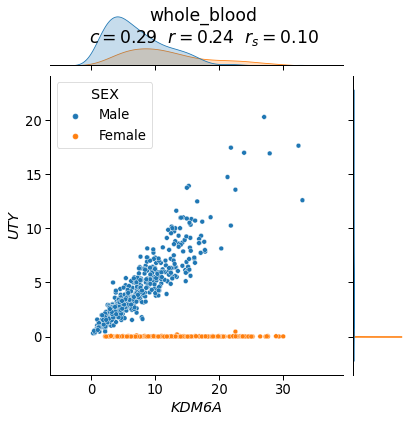

In [20]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Lowest tissues in clustermatch

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_uterus/samples-KDM6A_vs_UTY.svg')

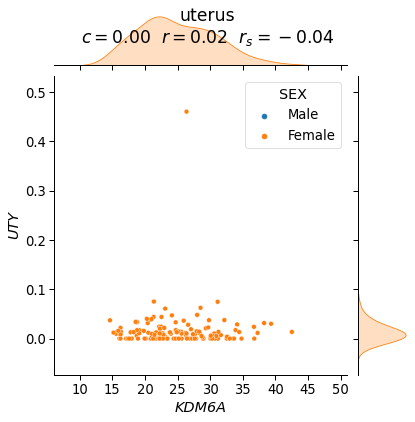

In [21]:
_tissue_data = plot_gene_pair(
    "uterus",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

In [22]:
# _tissue_data = plot_gene_pair(
#     "fallopian_tube",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

In [23]:
# _tissue_data = plot_gene_pair(
#     "kidney_medulla",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_ovary/samples-KDM6A_vs_UTY.svg')

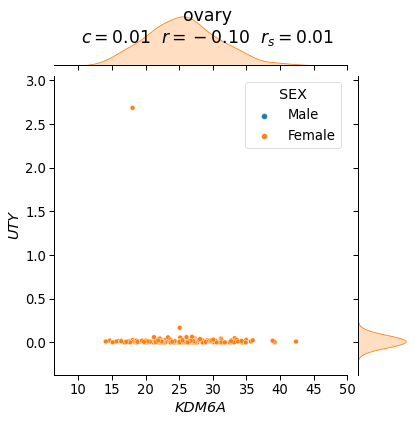

In [24]:
_tissue_data = plot_gene_pair(
    "ovary",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_vagina/samples-KDM6A_vs_UTY.svg')

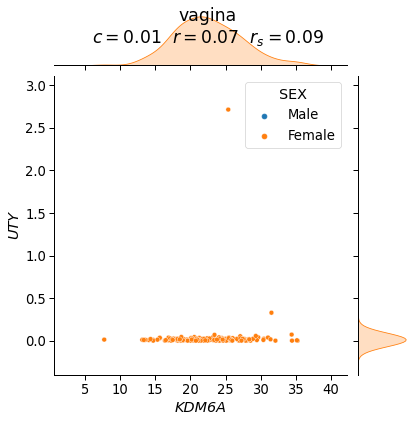

In [25]:
_tissue_data = plot_gene_pair(
    "vagina",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

In [26]:
# _tissue_data = plot_gene_pair(
#     "cervix_endocervix",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_brain_cerebellum/samples-KDM6A_vs_UTY.svg')

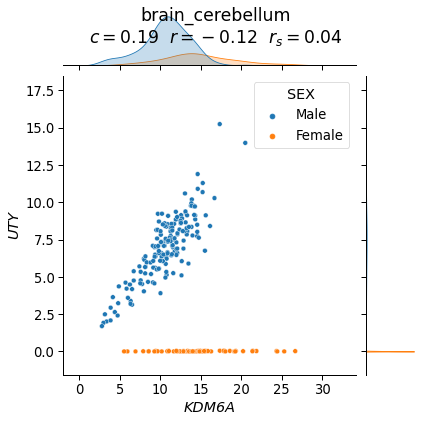

In [27]:
_tissue_data = plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_small_intestine_terminal_ileum/samples-KDM6A_vs_UTY.svg')

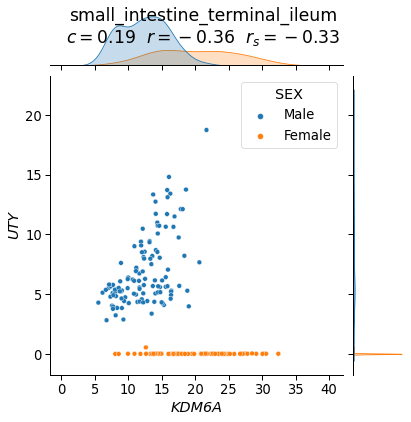

In [28]:
_tissue_data = plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_brain_spinal_cord_cervical_c1/samples-KDM6A_vs_UTY.svg')

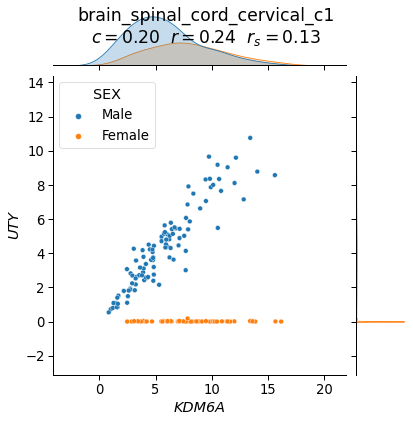

In [29]:
_tissue_data = plot_gene_pair(
    "brain_spinal_cord_cervical_c1",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_testis/samples-KDM6A_vs_UTY.svg')

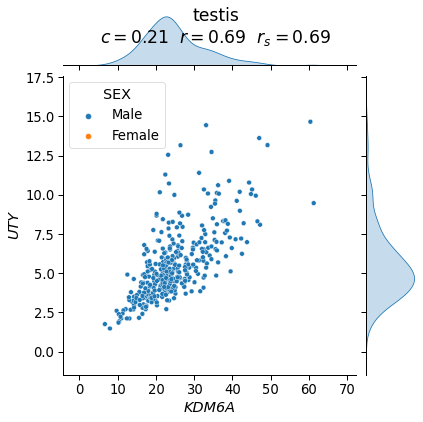

In [30]:
_tissue_data = plot_gene_pair(
    "testis",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Highest tissues in clustermatch

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_cells_cultured_fibroblasts/samples-KDM6A_vs_UTY.svg')

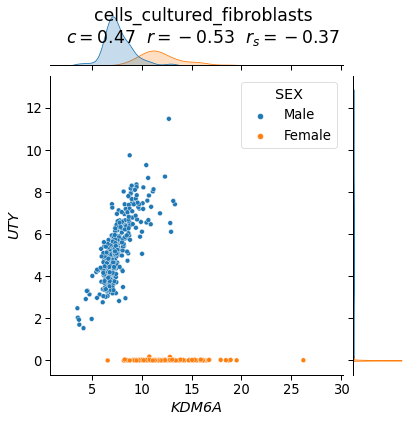

In [31]:
_tissue_data = plot_gene_pair(
    "cells_cultured_fibroblasts",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_breast_mammary_tissue/samples-KDM6A_vs_UTY.svg')

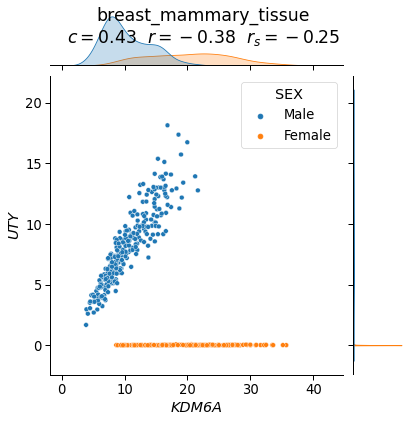

In [32]:
_tissue_data = plot_gene_pair(
    "breast_mammary_tissue",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Pearson low, Clustermatch high

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_brain_anterior_cingulate_cortex_ba24/samples-KDM6A_vs_UTY.svg')

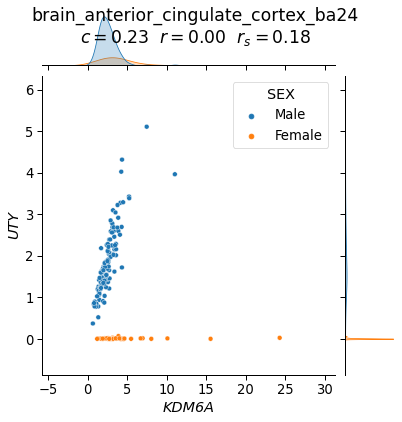

In [33]:
_tissue_data = plot_gene_pair(
    "brain_anterior_cingulate_cortex_ba24",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_brain_amygdala/samples-KDM6A_vs_UTY.svg')

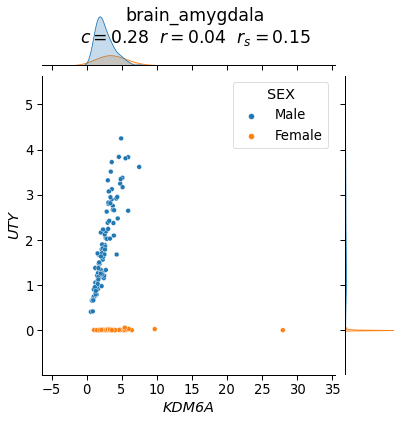

In [34]:
_tissue_data = plot_gene_pair(
    "brain_amygdala",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_brain_frontal_cortex_ba9/samples-KDM6A_vs_UTY.svg')

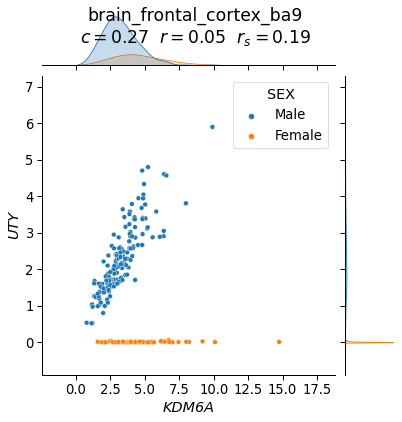

In [35]:
_tissue_data = plot_gene_pair(
    "brain_frontal_cortex_ba9",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_bladder/samples-KDM6A_vs_UTY.svg')

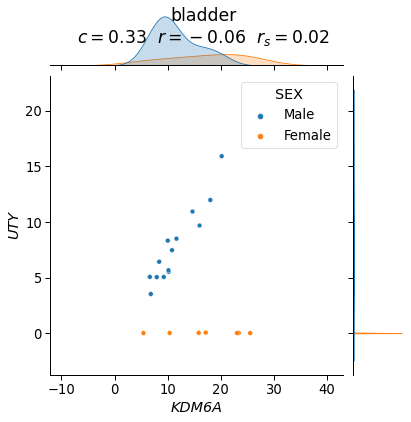

In [36]:
_tissue_data = plot_gene_pair(
    "bladder",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_heart_atrial_appendage/samples-KDM6A_vs_UTY.svg')

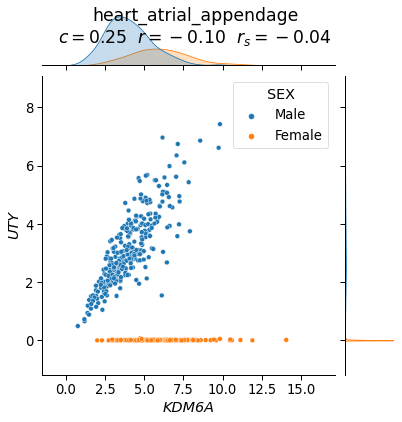

In [37]:
_tissue_data = plot_gene_pair(
    "heart_atrial_appendage",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Spearman low, Clustermatch high

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_heart_left_ventricle/samples-KDM6A_vs_UTY.svg')

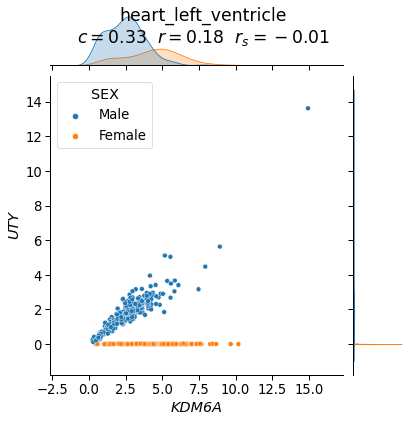

In [38]:
_tissue_data = plot_gene_pair(
    "heart_left_ventricle",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_adipose_visceral_omentum/samples-KDM6A_vs_UTY.svg')

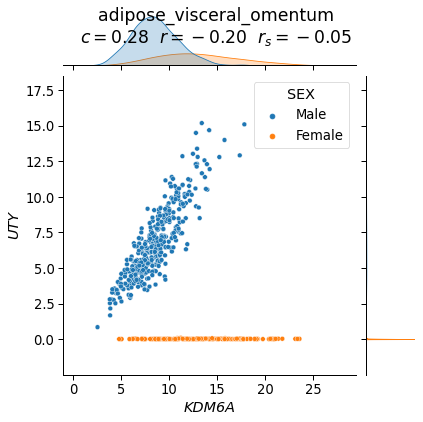

In [39]:
_tissue_data = plot_gene_pair(
    "adipose_visceral_omentum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_skin_not_sun_exposed_suprapubic/samples-KDM6A_vs_UTY.svg')

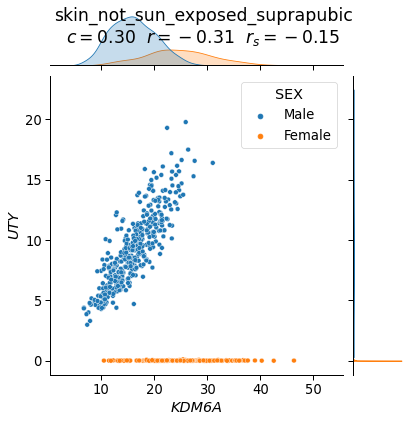

In [40]:
_tissue_data = plot_gene_pair(
    "skin_not_sun_exposed_suprapubic",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_pancreas/samples-KDM6A_vs_UTY.svg')

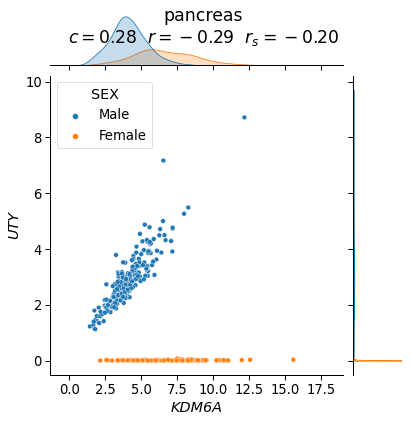

In [41]:
_tissue_data = plot_gene_pair(
    "pancreas",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)